<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/clickbait_image_tfrec_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 706kB 9.1MB/s 


#Imports

In [2]:
from __future__ import absolute_import, division, print_function
import os, sys, math
import numpy as np
import random
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


from importlib import reload



#Import custom script
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/scripts')


import tf_dataset_helpers as dh
import vgg16_model_helper as vggh

from tf_dataset_helpers import read_tfrec_data
import model_helpers as mh
import visualization_helpers as vh

#reload(mh)  # reload script if any changes there
#reload(dh)
#reload(vh)
#reload(vggh)




#Configurations

##Utilities

In [3]:
#@title "LR EXPLORATION"
class SGDRScheduler(tf.keras.callbacks.Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.

    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```

    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.

    # References
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        self.steps_per_epoch = self.params['steps'] if self.params['steps'] is not None else round(self.params['samples'] / self.params['batch_size'])
        logs = logs or {}
        tf.keras.backend.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)



class LrRangeFinder(tf.keras.callbacks.Callback):
  def __init__(self, start_lr, end_lr):
    super().__init__()
    self.start_lr = start_lr
    self.end_lr = end_lr 
       
  def on_train_begin(self, logs={}):
    self.lrs = []
    self.losses = []
    tf.keras.backend.set_value(self.model.optimizer.lr, self.start_lr)
    
    n_steps = self.params['steps'] if self.params['steps'] is not None else round(self.params['samples'] / self.params['batch_size'])
    n_steps *= self.params['epochs']
    self.by = (self.end_lr - self.start_lr) / n_steps
      

  def on_batch_end(self, batch, logs={}):
    lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
    self.lrs.append(lr)
    self.losses.append(logs.get('loss'))
    lr += self.by
    tf.keras.backend.set_value(self.model.optimizer.lr, lr)

In [4]:
#@title "Visualization:- RUN ME"
def display_9_images_from_batched_dataset_old(dataset, CLASSES):
  plt.figure(figsize=(13,13))
  subplot=331
  for image, label in display_train_ds:
    for i in range(len(image.numpy())):
      plt.subplot(subplot)
      plt.axis('off')
      plt.imshow(image[i].numpy().astype(np.uint8))
      plt.title(CLASSES[label[i].numpy()], fontsize=16)
      subplot += 1
      if i==8:
        break
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_9_images_from_batched_dataset(dataset):
  plt.figure(figsize=(13,13))
  #subplot=331
  for image, label in display_train_ds:
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      #plt.subplot(subplot)
      plt.axis('off')
      plt.imshow(image[i].numpy().astype(np.uint8))
      plt.title(CLASSES[label[i].numpy()], fontsize=16)
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

In [5]:
#@title "Callbacks - RUN ME"
def get_callbacks(checkpoint_path):
  es = tf.keras.callbacks.EarlyStopping(monitor='val_prc', 
                                        verbose=1, 
                                        patience=10, 
                                        mode='max', 
                                        restore_best_weights=True)

  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
     filepath=checkpoint_path,
     save_weights_only=True,
     monitor='val_prc',
     mode='max',
     verbose=1,
     save_best_only=True)

  return [es, model_checkpoint_callback]


##Configs

In [6]:
PATH_OUTPUT = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/tfrec/tfrec_data/'

TARGET_SIZE = [180, 180]
CLASSES = [b'nonclickbaits', b'clickbaits'] 
BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)
VALIDATION_SPLIT = 0.3
TESTING_SPLIT = 0.5
WIDTH = 180
HEIGHT = 180
IMG_SIZE = 224
NUM_CLASSES=1

In [7]:
#Save weights
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models/Checkpoints'
efficientNet_B0_model_weight_path = os.path.join(checkpoint_filepath, 'efficientNet_B0_weights.h5')

#Save model
MODEL_SAVE_PATH ='/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models'
efficientNet_B0_model_path = os.path.join(MODEL_SAVE_PATH, 'efficientNet_B0_model')


In [8]:
#instantiate read_data utility
read_data = read_tfrec_data(PATH_OUTPUT, TARGET_SIZE=TARGET_SIZE, MODE=0, SHUFFLE_BUFFER=1000)

# splitting data files between training, validation and test
filenames, training_filenames, validation_filenames, testing_filenames = read_data.get_tfrec_files()

validation_steps = int(15572 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(15572 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 12 training files , 2 validation files and 2 test files
With a batch size of 32, there will be 364 batches per training epoch and 60 batch(es) per validation run.


#Load data

In [9]:
def _resize_img(img, label):
    size = (IMG_SIZE, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, size)
    return (img, label)


In [10]:
# instantiate the datasets
train_ds = read_data.get_batched_dataset(training_filenames, train=True)
train_ds = train_ds.map(_resize_img)
val_ds = read_data.get_batched_dataset(validation_filenames, train=False)
val_ds = val_ds.map(_resize_img)
test_ds = read_data.get_batched_dataset(testing_filenames, train=False)
test_ds = test_ds.map(_resize_img)

#Viusualize data

In [11]:
display_train_ds = train_ds.take(3)
for img,label in display_train_ds:
  for i in range(1):
    print(f'{img[i].numpy().shape}')
    #print(f'{img[i].numpy()}')

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


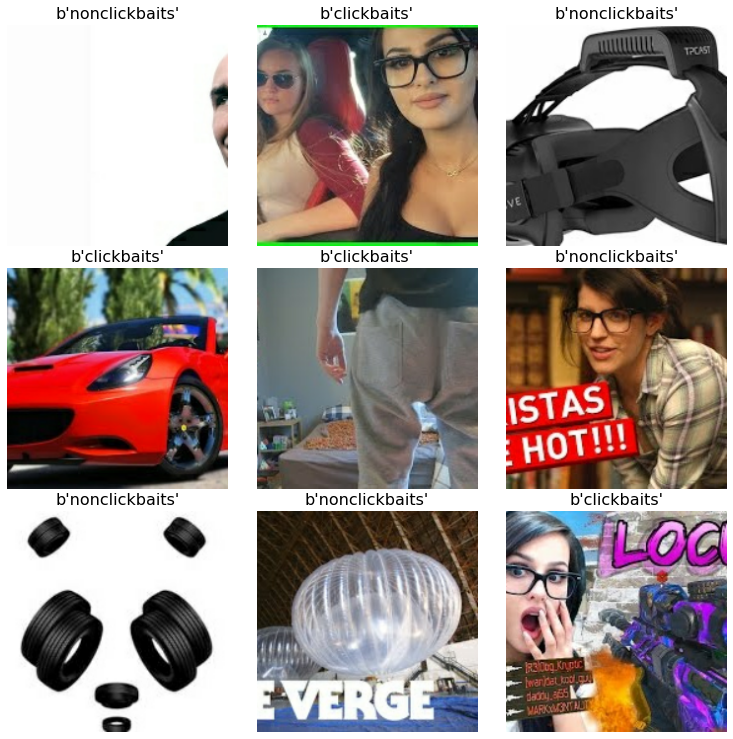

In [12]:
display_train_ds = train_ds.take(1)
display_9_images_from_batched_dataset_old(display_train_ds, CLASSES)

#Data augmentation

In [13]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
        preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1),
    ],
    name="img_augmentation",
)

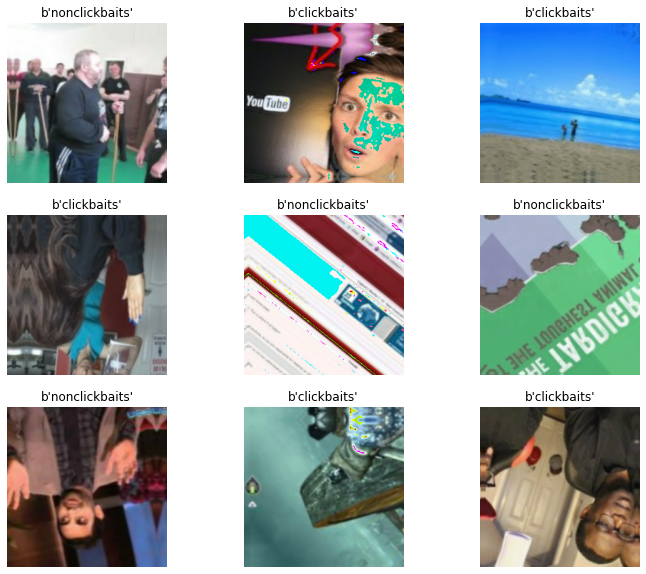

In [14]:
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image[i], axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(CLASSES[label[i]]))
        plt.axis("off")

#Build model

In [18]:
from tensorflow.keras.layers.experimental import preprocessing


def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    
    return model

In [19]:
model_v1 = build_model()
model_v1.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           img_augmentation[1][0]           
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
_______________________________________________________________________________________

#Training

###V1

In [20]:
callbacks = get_callbacks(efficientNet_B0_model_weight_path)
  
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
  )
optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

if os.path.exists(efficientNet_B0_model_weight_path):
  #print('loading weight')
  model_v1.load_weights(efficientNet_B0_model_weight_path)

model_v1, model_v1_history = mh.compile_train_model( model_v1,
                                                     train_ds, 
                                                     val_ds,
                                                     steps_per_epoch=steps_per_epoch,
                                                     validation_steps=validation_steps,
                                                     EPOCHS=50,
                                                     OPTIMIZER = optim,
                                                     CALLBACKS = callbacks,
                                                     save_model = True,
                                                     model_save_path=efficientNet_B0_model_path)

Epoch 1/50
364/364 [==============================] - 43s 101ms/step - loss: 0.7231 - tp: 4063.0685 - fp: 3757.3534 - tn: 2237.1479 - fn: 982.3425 - accuracy: 0.5585 - precision: 0.5138 - recall: 0.8244 - auc: 0.5619 - prc: 0.4809 - val_loss: 0.5490 - val_tp: 578.0000 - val_fp: 243.0000 - val_tn: 811.0000 - val_fn: 288.0000 - val_accuracy: 0.7234 - val_precision: 0.7040 - val_recall: 0.6674 - val_auc: 0.8043 - val_prc: 0.7440

Epoch 00001: val_prc improved from -inf to 0.74403, saving model to /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/image_models/Checkpoints/efficientNet_B0_weights.h5
Epoch 2/50
364/364 [==============================] - 35s 95ms/step - loss: 0.5930 - tp: 1821.0274 - fp: 846.6356 - tn: 2313.2548 - fn: 874.9945 - accuracy: 0.7068 - precision: 0.6805 - recall: 0.6723 - auc: 0.7710 - prc: 0.7181 - val_loss: 0.5173 - val_tp: 634.0000 - val_fp: 238.0000 - val_tn: 816.0000 - val_fn: 232.0000 - val_accuracy: 0.7552 - val_precision: 0.7271 - val_recall

#Plot training history

###V1

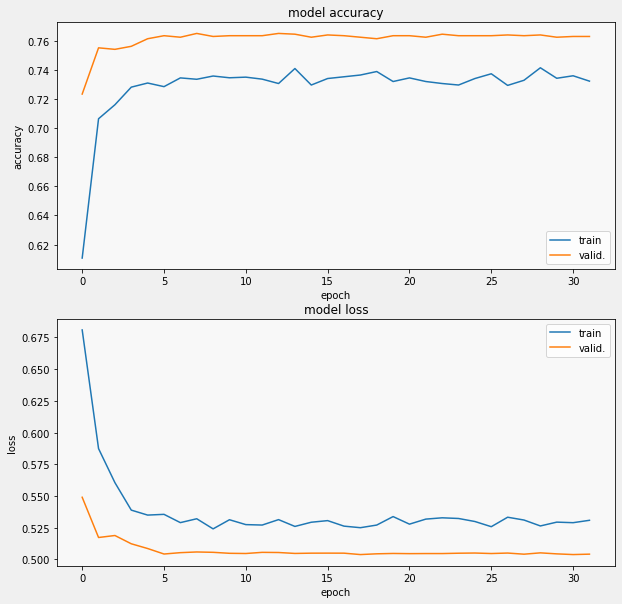

In [21]:
vh.display_training_curves(model_v1_history.history['accuracy'], model_v1_history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(model_v1_history.history['loss'], model_v1_history.history['val_loss'], 'loss', 212)

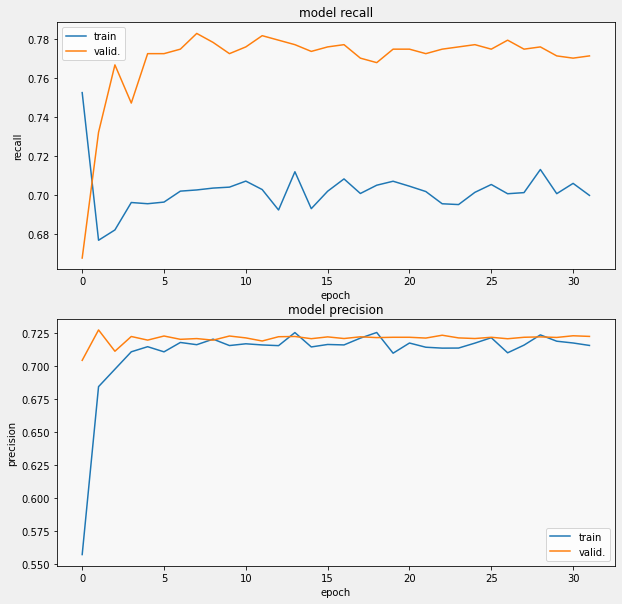

In [22]:
vh.display_training_curves(model_v1_history.history['recall'], model_v1_history.history['val_recall'], 'recall', 211)
vh.display_training_curves(model_v1_history.history['precision'], model_v1_history.history['val_precision'], 'precision', 212)

#Model evaluation and Predictions

###V1

61/61 [==============================] - 8s 97ms/step - loss: 0.4958 - tp: 695.0000 - fp: 262.0000 - tn: 790.0000 - fn: 201.0000 - accuracy: 0.7623 - precision: 0.7262 - recall: 0.7757 - auc: 0.8387 - prc: 0.8005
loss :  0.495815247297287
tp :  695.0
fp :  262.0
tn :  790.0
fn :  201.0
accuracy :  0.762320339679718
precision :  0.7262278199195862
recall :  0.7756696343421936
auc :  0.8387261629104614
prc :  0.8005368113517761



Accuracy: 0.752083
Precision: 0.702355
Recall: 0.768150
F1 score: 0.733781
ROC AUC: 0.753681
[[394 139]
 [ 99 328]]
Non clickbaits Detected (True Negatives):  394
Non-Clickbaits Detected as Clickbaits (False Positives):  139
Clickbaits Detected as Non-clickbaits (False Negatives):  99
Clickbaits Detected (True Positives):  328
Total Non-clickbaits:  533
Total Clickbaits:  427



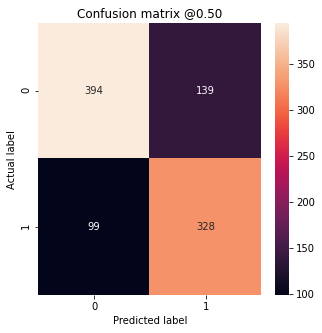

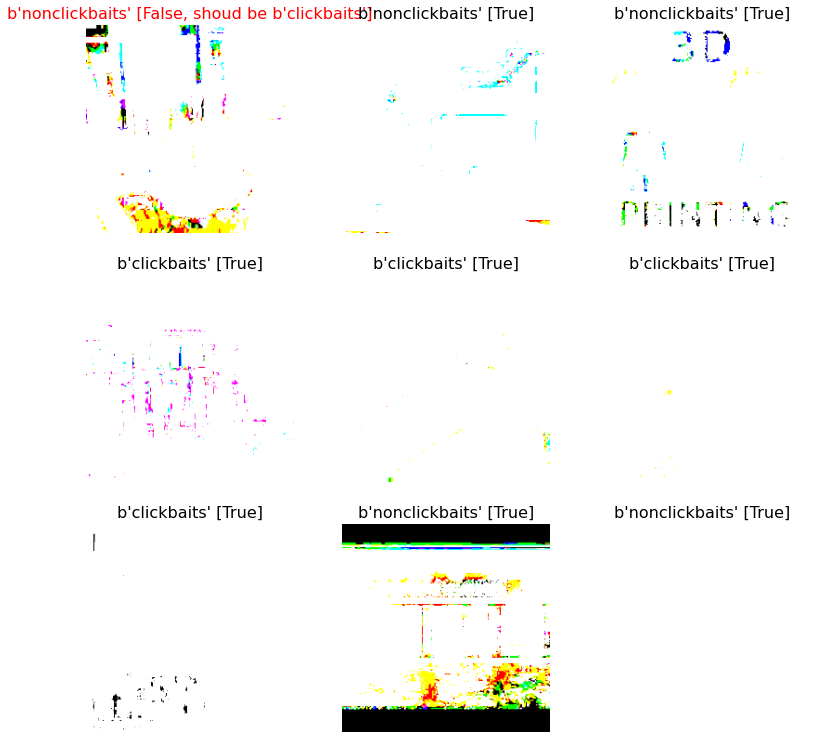

In [23]:
saved_model_efficientNet_B0_v1 = keras.models.load_model(efficientNet_B0_model_path)
results = saved_model_efficientNet_B0_v1.evaluate(test_ds)

for name, value in zip(saved_model_efficientNet_B0_v1.metrics_names, results):
  print(name, ': ', value)
print()

test_image, y_true, y_pred, predicted_scores = mh.predict_on_test_vis(saved_model_efficientNet_B0_v1,test_ds, BATCH_SIZE=BATCH_SIZE, N=30)
vh.display_9_images_with_predictions(test_image[30:], y_pred[30:], y_true[30:], CLASSES=CLASSES)